# Análisis de Frecuencia y Ley de Zipf
Para automatizar el procesamiento de lenguaje, primero debemos entender la estadística detrás de las palabras.
Vamos a usar `tiktoken` (el tokenizador de GPT-4) y datos reales de la web para analizar frecuencias.

### 1. Configuración e Importación
Instalamos las librerías necesarias y preparamos el entorno gráfico.

In [1]:
# Importaciones para obtener datos web y graficar
import requests
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# Gráficos de alta calidad
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Instalamos e importamos tiktoken
!pip install tiktoken
import tiktoken

# Inicializamos el tokenizador de GPT-4
tokenizer = tiktoken.get_encoding('cl100k_base')

# Ejercicio 1: Contando ocurrencias (Números vs Letras)

`numpy` es excelente para contar números repetidos, pero requiere un truco extra para trabajar con texto crudo.

Primero, veamos cómo funciona `np.unique` con una lista de números.

In [2]:
# Intro rápida a np.unique con números
nums = np.array([ 1,1,3,2,2,2,9,9,9,-1,-1,-1,-1,-1 ])

# return_counts=True nos devuelve también cuántas veces aparece cada uno
uniq, counts = np.unique(nums, return_counts=True)

for n, c in zip(uniq, counts):
    print(f'El número {n} aparece {c} veces.')

El número -1 aparece 5 veces.
El número 1 aparece 2 veces.
El número 2 aparece 3 veces.
El número 3 aparece 1 veces.
El número 9 aparece 3 veces.


Ahora intentemos hacer lo mismo con un texto (string).
Si intentamos `np.unique(texto_string)`, Python lo ve como un único objeto. Para analizar carácter por carácter, necesitamos convertirlo o iterar sobre un conjunto (`set`) de caracteres únicos.

In [3]:
text = 'Hello, my name is Mike and I like to eat chocolate.'

# Esto no funciona como esperamos (trata la frase entera como un elemento)
# np.unique(text)

# Solución manual para caracteres:
# 1. Obtenemos los caracteres únicos usando set() y los ordenamos
uniq = sorted(set(text))

# 2. Preparamos un array de ceros para guardar los conteos
counts = np.zeros(len(uniq))

# 3. Contamos manualmente
for i, u in enumerate(uniq):
    counts[i] = text.count(u)

# O usando comprensión de listas (más "Pythonic")
# counts = [text.count(u) for u in uniq]

# Imprimimos resultados
print("Conteo de caracteres:")
for n, c in zip(uniq, counts):
    # Imprimimos solo si aparece (aunque aquí todos aparecen al menos una vez)
    print(f'El caracter "{n}" aparece {int(c)} veces.')

Conteo de caracteres:
El caracter " " aparece 10 veces.
El caracter "," aparece 1 veces.
El caracter "." aparece 1 veces.
El caracter "H" aparece 1 veces.
El caracter "I" aparece 1 veces.
El caracter "M" aparece 1 veces.
El caracter "a" aparece 4 veces.
El caracter "c" aparece 2 veces.
El caracter "d" aparece 1 veces.
El caracter "e" aparece 6 veces.
El caracter "h" aparece 1 veces.
El caracter "i" aparece 3 veces.
El caracter "k" aparece 2 veces.
El caracter "l" aparece 4 veces.
El caracter "m" aparece 2 veces.
El caracter "n" aparece 2 veces.
El caracter "o" aparece 4 veces.
El caracter "s" aparece 1 veces.
El caracter "t" aparece 3 veces.
El caracter "y" aparece 1 veces.


### Ejercicio 2: Explorando la Ley de Zipf en Libros Reales

La **Ley de Zipf** establece que la frecuencia de una palabra es inversamente proporcional a su ranking. Es decir, la palabra más usada aparece el doble que la segunda, el triple que la tercera, etc.

Vamos a descargar dos libros clásicos del Proyecto Gutenberg ("La Máquina del Tiempo" y "Drácula") y visualizaremos si cumplen esta ley:
1.  A nivel de caracteres.
2.  A nivel de tokens (como lo ve GPT-4).

Descargando The Time Machine...
Descargando Dracula...


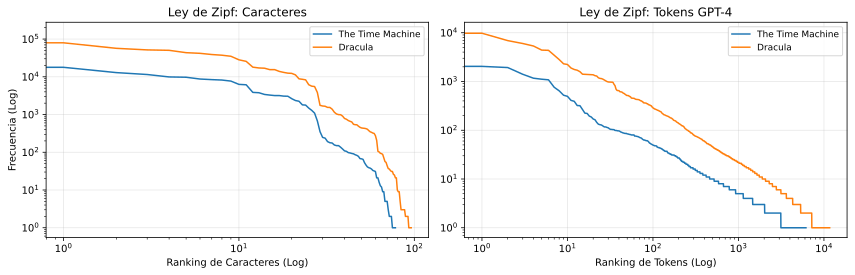

In [4]:
# Diccionario con libros del Proyecto Gutenberg
# (ID 35: Time Machine, ID 345: Dracula)
bookurls = [
    ('https://www.gutenberg.org/files/35/35-0.txt', 'The Time Machine'),
    ('https://www.gutenberg.org/files/345/345-0.txt', 'Dracula')
]

# Preparamos la figura con 2 sub-gráficos
_, axs = plt.subplots(1, 2, figsize=(12, 4))

for url, title in bookurls:
    # 1. Obtener el texto de la web
    print(f"Descargando {title}...")
    try:
        response = requests.get(url)
        response.encoding = 'utf-8' # Asegurar codificación correcta
        text = response.text
    except Exception as e:
        print(f"Error descargando {title}: {e}")
        continue

    # --- Análisis de Caracteres ---
    # Convertimos el texto a lista de caracteres para np.unique
    # return_counts=True nos da las frecuencias
    _, char_counts = np.unique(list(text), return_counts=True)

    # IMPORTANTE: Para la Ley de Zipf, ordenamos de mayor a menor frecuencia
    char_counts_sorted = np.sort(char_counts)[::-1]

    # Graficamos en el primer panel (Escala Logarítmica para ver la ley de potencia)
    axs[0].plot(char_counts_sorted, label=title)


    # --- Análisis de Tokens (GPT-4) ---
    # Tokenizamos el texto completo
    tokens = tokenizer.encode(text)

    # Contamos frecuencias de tokens
    _, token_counts = np.unique(tokens, return_counts=True)

    # Ordenamos de mayor a menor
    token_counts_sorted = np.sort(token_counts)[::-1]

    # Graficamos en el segundo panel
    axs[1].plot(token_counts_sorted, label=title)


# Ajustes visuales de los gráficos
for a in axs:
    a.legend(fontsize=9)
    # La Ley de Zipf se ve mejor en escala log-log
    a.set_xscale('log')
    a.set_yscale('log')
    a.grid(alpha=0.3)

# Títulos y etiquetas
axs[0].set_title('Ley de Zipf: Caracteres')
axs[0].set_ylabel('Frecuencia (Log)')
axs[0].set_xlabel('Ranking de Caracteres (Log)')

axs[1].set_title('Ley de Zipf: Tokens GPT-4')
axs[1].set_xlabel('Ranking de Tokens (Log)')

plt.tight_layout()
plt.show()

### Conclusión del Gráfico

Deberías ver líneas descendentes casi rectas en el gráfico logarítmico. Esto confirma que el lenguaje humano (ya sea en caracteres o tokens) sigue una distribución de potencia muy específica.

Esto es útil para tus automatizaciones porque te enseña que hay pocas palabras/tokens que se repiten muchísimo ("el", "de", "que") y una cola larga de palabras raras. Los modelos de IA aprenden a predecir basándose en estas probabilidades.